# Convolutional Neural Network

The last method we cover, is the convolutional neural network. We have chosen to implement the CNN called LeNet. LeNet has the structure below. LeNet takes a 28x28 greyscale image, and runs it sequentially through two convolution layers (each consisting of a convolution, an activation function and a pooling layer.). The second convolutional layer feeds the output to a fully connected neural network. In our implementation, we also introduce a dropout layer after the first fully connected layer. This prevents overfitting. Furthermore we also do early stopping to prevent overfitting on the training dataset.


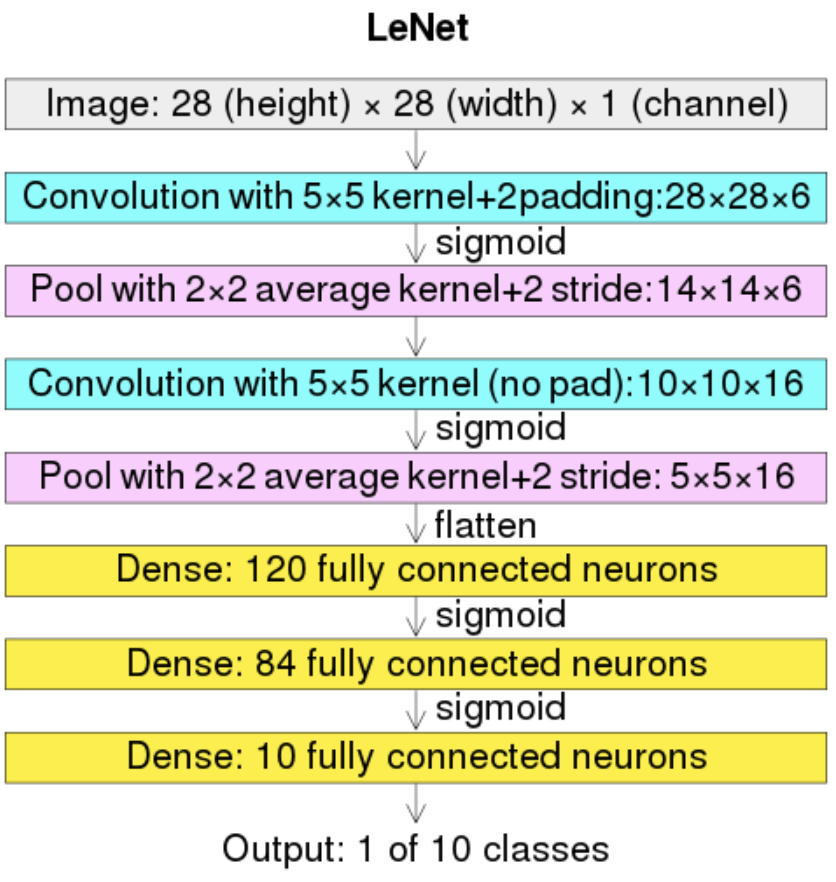

In [118]:
# Libaries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torchinfo import summary
import torchvision


from sklearn.metrics import *


In [2]:
# Load data

train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784] / 255, train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784] / 255, test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}


To allow early stopping, we split the dataset into training, validation and test dataset. These consist of 53.3%, 13.3% and 33.3%

In [3]:
cnn_X_train = X_train.reshape(-1,28,28)
X_tensor = torch.from_numpy(cnn_X_train).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_train).long()
cnn_train_data = TensorDataset(X_tensor, y_tensor)

cnn_X_test = X_test.reshape(-1,28,28)
X_test_tensor = torch.from_numpy(cnn_X_test).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).long()
cnn_test_data = TensorDataset(X_test_tensor, y_test_tensor)

cnn_train_data, cnn_validation_data = torch.utils.data.random_split(cnn_train_data, [8000, 2000]) 

In [29]:
# We create a dataloader for train and test
BATCH_SIZE = 128

loaders = {
    'train' : DataLoader(cnn_train_data,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
        
    'validation'  : DataLoader(cnn_validation_data, 
                                          batch_size=BATCH_SIZE,
                                          num_workers=1,
                                          ),

    'test'  : DataLoader(cnn_test_data, 
                                          batch_size=BATCH_SIZE, 
                                          num_workers=1,
                                          )
}


In [65]:
# We define the LeNet

class CNN(nn.Module):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []

        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )

        self.fully_connected = nn.Sequential(
            # FFNN Layer 1
            nn.Linear(in_features=16*5*5,out_features=120), 
            nn.Sigmoid(),
            nn.Dropout(p=0.2),

            # FFNN Layer 2
            nn.Linear(in_features=120,out_features=84), 
            nn.Sigmoid(),
            
            # FFNN Output layer
            nn.Linear(in_features=84,out_features=N_CLASSES) 
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.fully_connected(x)
        return output



# initialise it
conv_nn = CNN()


def train(n_epochs, ann, loaders, learning_rate=0.05):
    min_valid_loss = np.inf
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    ann.to(device)

    for epoch in tqdm(range(n_epochs)):
        epoch_train_loss = 0
        ann.train()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(ann.parameters(), lr=learning_rate)

        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            output = ann(images)

            loss = loss_fn(output, labels)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        epoch_val_loss = 0
        ann.eval()

        for images_v, labels_v in loaders['validation']:
            images_v, labels_v = images_v.to(device), labels_v.to(device)

            output = ann(images_v)
            loss_v = loss_fn(output, labels_v)
            epoch_val_loss += loss_v.item()
        
        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')

        

        print('-------------------')
        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss/ len(loaders["validation"])}--->{epoch_val_loss/ len(loaders["validation"])}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
          # Saving State Dict
            torch.save(ann.state_dict(), 'data/saved_model.pth')

summary(conv_nn,input_size=[8000,1,28,28])



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [8000, 5]                 --
├─Sequential: 1-1                        [8000, 6, 14, 14]         --
│    └─Conv2d: 2-1                       [8000, 6, 28, 28]         156
│    └─Sigmoid: 2-2                      [8000, 6, 28, 28]         --
│    └─AvgPool2d: 2-3                    [8000, 6, 14, 14]         --
├─Sequential: 1-2                        [8000, 16, 5, 5]          --
│    └─Conv2d: 2-4                       [8000, 16, 10, 10]        2,416
│    └─Sigmoid: 2-5                      [8000, 16, 10, 10]        --
│    └─AvgPool2d: 2-6                    [8000, 16, 5, 5]          --
├─Sequential: 1-3                        [8000, 5]                 --
│    └─Linear: 2-7                       [8000, 120]               48,120
│    └─Sigmoid: 2-8                      [8000, 120]               --
│    └─Dropout: 2-9                      [8000, 120]               --
│    └─

In [66]:
train(100, conv_nn, loaders, 0.005)



  1%|          | 1/100 [00:02<04:37,  2.81s/it]

Epoch 1
Training Loss: 1.5055713596798124
Validation Loss: 1.1142384484410286
-------------------
Validation Loss Decreased(inf--->1.1142384484410286) 	 Saving The Model


  2%|▏         | 2/100 [00:05<04:17,  2.63s/it]

Epoch 2
Training Loss: 0.9904937687374297
Validation Loss: 0.8550075255334377
-------------------
Validation Loss Decreased(1.1142384484410286--->0.8550075255334377) 	 Saving The Model


  3%|▎         | 3/100 [00:07<04:12,  2.61s/it]

Epoch 3
Training Loss: 0.8091669763837542
Validation Loss: 0.720376156270504
-------------------
Validation Loss Decreased(0.8550075255334377--->0.720376156270504) 	 Saving The Model


  4%|▍         | 4/100 [00:10<04:05,  2.56s/it]

Epoch 4
Training Loss: 0.6972356287259904
Validation Loss: 0.6777207404375076
-------------------
Validation Loss Decreased(0.720376156270504--->0.6777207404375076) 	 Saving The Model


  5%|▌         | 5/100 [00:12<03:59,  2.52s/it]

Epoch 5
Training Loss: 0.6489643577545409
Validation Loss: 0.6249312907457352
-------------------
Validation Loss Decreased(0.6777207404375076--->0.6249312907457352) 	 Saving The Model


  6%|▌         | 6/100 [00:15<03:57,  2.52s/it]

Epoch 6
Training Loss: 0.6164828354404086
Validation Loss: 0.6027296390384436
-------------------
Validation Loss Decreased(0.6249312907457352--->0.6027296390384436) 	 Saving The Model


  7%|▋         | 7/100 [00:17<03:57,  2.55s/it]

Epoch 7
Training Loss: 0.5837698829552483
Validation Loss: 0.5722703486680984
-------------------
Validation Loss Decreased(0.6027296390384436--->0.5722703486680984) 	 Saving The Model


  8%|▊         | 8/100 [00:20<03:47,  2.47s/it]

Epoch 8
Training Loss: 0.5573085537032475
Validation Loss: 0.5594647936522961
-------------------
Validation Loss Decreased(0.5722703486680984--->0.5594647936522961) 	 Saving The Model


  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

Epoch 9
Training Loss: 0.5382555548160796
Validation Loss: 0.5375152230262756
-------------------
Validation Loss Decreased(0.5594647936522961--->0.5375152230262756) 	 Saving The Model


 10%|█         | 10/100 [00:25<03:46,  2.52s/it]

Epoch 10
Training Loss: 0.5159797133907439
Validation Loss: 0.505044236779213
-------------------
Validation Loss Decreased(0.5375152230262756--->0.505044236779213) 	 Saving The Model


 11%|█         | 11/100 [00:28<03:47,  2.56s/it]

Epoch 11
Training Loss: 0.49270699989228023
Validation Loss: 0.4979941938072443
-------------------
Validation Loss Decreased(0.505044236779213--->0.4979941938072443) 	 Saving The Model


 12%|█▏        | 12/100 [00:30<03:51,  2.64s/it]

Epoch 12
Training Loss: 0.4746046643408518
Validation Loss: 0.49493728019297123
-------------------
Validation Loss Decreased(0.4979941938072443--->0.49493728019297123) 	 Saving The Model


 13%|█▎        | 13/100 [00:33<03:45,  2.59s/it]

Epoch 13
Training Loss: 0.46535096045524355
Validation Loss: 0.459676681086421
-------------------
Validation Loss Decreased(0.49493728019297123--->0.459676681086421) 	 Saving The Model


 14%|█▍        | 14/100 [00:35<03:40,  2.57s/it]

Epoch 14
Training Loss: 0.4459344001989516
Validation Loss: 0.4521177988499403
-------------------
Validation Loss Decreased(0.459676681086421--->0.4521177988499403) 	 Saving The Model


 15%|█▌        | 15/100 [00:38<03:39,  2.58s/it]

Epoch 15
Training Loss: 0.43773102949536036
Validation Loss: 0.4710242450237274
-------------------


 16%|█▌        | 16/100 [00:41<03:36,  2.57s/it]

Epoch 16
Training Loss: 0.42461979294580127
Validation Loss: 0.4462087359279394
-------------------
Validation Loss Decreased(0.4521177988499403--->0.4462087359279394) 	 Saving The Model


 17%|█▋        | 17/100 [00:43<03:32,  2.57s/it]

Epoch 17
Training Loss: 0.4105995377850911
Validation Loss: 0.41553102247416973
-------------------
Validation Loss Decreased(0.4462087359279394--->0.41553102247416973) 	 Saving The Model


 18%|█▊        | 18/100 [00:45<03:26,  2.52s/it]

Epoch 18
Training Loss: 0.4145930395239875
Validation Loss: 0.43011182732880116
-------------------


 19%|█▉        | 19/100 [00:48<03:23,  2.51s/it]

Epoch 19
Training Loss: 0.4011454279460604
Validation Loss: 0.4165473487228155
-------------------


 20%|██        | 20/100 [00:50<03:17,  2.47s/it]

Epoch 20
Training Loss: 0.38451138517213246
Validation Loss: 0.41742464900016785
-------------------


 21%|██        | 21/100 [00:53<03:12,  2.44s/it]

Epoch 21
Training Loss: 0.3707251473078652
Validation Loss: 0.4014052003622055
-------------------
Validation Loss Decreased(0.41553102247416973--->0.4014052003622055) 	 Saving The Model


 22%|██▏       | 22/100 [00:55<03:10,  2.45s/it]

Epoch 22
Training Loss: 0.37051179106273346
Validation Loss: 0.3864970151335001
-------------------
Validation Loss Decreased(0.4014052003622055--->0.3864970151335001) 	 Saving The Model


 23%|██▎       | 23/100 [00:58<03:12,  2.50s/it]

Epoch 23
Training Loss: 0.359413539369901
Validation Loss: 0.38573105074465275
-------------------
Validation Loss Decreased(0.3864970151335001--->0.38573105074465275) 	 Saving The Model


 24%|██▍       | 24/100 [01:00<03:12,  2.53s/it]

Epoch 24
Training Loss: 0.35321398292269024
Validation Loss: 0.38530064187943935
-------------------
Validation Loss Decreased(0.38573105074465275--->0.38530064187943935) 	 Saving The Model


 25%|██▌       | 25/100 [01:03<03:06,  2.49s/it]

Epoch 25
Training Loss: 0.3421877958471813
Validation Loss: 0.3869422096759081
-------------------


 26%|██▌       | 26/100 [01:05<03:01,  2.46s/it]

Epoch 26
Training Loss: 0.33751577399079763
Validation Loss: 0.38897128961980343
-------------------


 27%|██▋       | 27/100 [01:08<03:00,  2.48s/it]

Epoch 27
Training Loss: 0.3336943250799936
Validation Loss: 0.37439494021236897
-------------------
Validation Loss Decreased(0.38530064187943935--->0.37439494021236897) 	 Saving The Model


 28%|██▊       | 28/100 [01:11<03:11,  2.66s/it]

Epoch 28
Training Loss: 0.33018115257459973
Validation Loss: 0.36388179659843445
-------------------
Validation Loss Decreased(0.37439494021236897--->0.36388179659843445) 	 Saving The Model


 29%|██▉       | 29/100 [01:14<03:10,  2.69s/it]

Epoch 29
Training Loss: 0.3231548671684568
Validation Loss: 0.36835833452641964
-------------------


 30%|███       | 30/100 [01:16<03:08,  2.70s/it]

Epoch 30
Training Loss: 0.3187594004566707
Validation Loss: 0.3689721170812845
-------------------


 31%|███       | 31/100 [01:19<03:08,  2.73s/it]

Epoch 31
Training Loss: 0.309386240111457
Validation Loss: 0.366674380376935
-------------------


 32%|███▏      | 32/100 [01:22<03:04,  2.71s/it]

Epoch 32
Training Loss: 0.30560765734740664
Validation Loss: 0.3622657833620906
-------------------
Validation Loss Decreased(0.36388179659843445--->0.3622657833620906) 	 Saving The Model


 33%|███▎      | 33/100 [01:24<03:01,  2.71s/it]

Epoch 33
Training Loss: 0.3007501406329019
Validation Loss: 0.3818638175725937
-------------------


 34%|███▍      | 34/100 [01:27<02:56,  2.67s/it]

Epoch 34
Training Loss: 0.3022956919102442
Validation Loss: 0.3928167913109064
-------------------


 35%|███▌      | 35/100 [01:30<02:50,  2.63s/it]

Epoch 35
Training Loss: 0.2871529504893318
Validation Loss: 0.37012561969459057
-------------------


 36%|███▌      | 36/100 [01:32<02:48,  2.63s/it]

Epoch 36
Training Loss: 0.2842488816333196
Validation Loss: 0.37183917313814163
-------------------


 37%|███▋      | 37/100 [01:35<02:44,  2.61s/it]

Epoch 37
Training Loss: 0.28097202262235066
Validation Loss: 0.3698558658361435
-------------------


 38%|███▊      | 38/100 [01:37<02:42,  2.63s/it]

Epoch 38
Training Loss: 0.2726649935283358
Validation Loss: 0.37152943201363087
-------------------


 39%|███▉      | 39/100 [01:40<02:40,  2.63s/it]

Epoch 39
Training Loss: 0.27585204868089586
Validation Loss: 0.37339816987514496
-------------------


 40%|████      | 40/100 [01:43<02:38,  2.64s/it]

Epoch 40
Training Loss: 0.26748012313767083
Validation Loss: 0.3698952663689852
-------------------


 41%|████      | 41/100 [01:45<02:34,  2.62s/it]

Epoch 41
Training Loss: 0.27104945409865605
Validation Loss: 0.3733287490904331
-------------------


 42%|████▏     | 42/100 [01:48<02:30,  2.59s/it]

Epoch 42
Training Loss: 0.26587563871391234
Validation Loss: 0.37319127283990383
-------------------


 43%|████▎     | 43/100 [01:50<02:27,  2.60s/it]

Epoch 43
Training Loss: 0.25977577008898295
Validation Loss: 0.3852923531085253
-------------------


 44%|████▍     | 44/100 [01:53<02:26,  2.62s/it]

Epoch 44
Training Loss: 0.2586708144536094
Validation Loss: 0.38033016957342625
-------------------


 45%|████▌     | 45/100 [01:56<02:22,  2.58s/it]

Epoch 45
Training Loss: 0.24400443560074245
Validation Loss: 0.3716641403734684
-------------------


 46%|████▌     | 46/100 [01:58<02:19,  2.58s/it]

Epoch 46
Training Loss: 0.24234901250354826
Validation Loss: 0.3956554736942053
-------------------


 47%|████▋     | 47/100 [02:01<02:15,  2.56s/it]

Epoch 47
Training Loss: 0.23480981399142553
Validation Loss: 0.37602300476282835
-------------------


 48%|████▊     | 48/100 [02:03<02:13,  2.56s/it]

Epoch 48
Training Loss: 0.2418213685353597
Validation Loss: 0.37618931382894516
-------------------


 49%|████▉     | 49/100 [02:06<02:09,  2.54s/it]

Epoch 49
Training Loss: 0.22644097156940945
Validation Loss: 0.3981941919773817
-------------------


 50%|█████     | 50/100 [02:08<02:06,  2.52s/it]

Epoch 50
Training Loss: 0.23735058851658353
Validation Loss: 0.37738765962421894
-------------------


 51%|█████     | 51/100 [02:11<02:04,  2.53s/it]

Epoch 51
Training Loss: 0.22578070844922746
Validation Loss: 0.37837475817650557
-------------------


 52%|█████▏    | 52/100 [02:13<02:01,  2.53s/it]

Epoch 52
Training Loss: 0.21854817713536914
Validation Loss: 0.377061165869236
-------------------


 53%|█████▎    | 53/100 [02:16<02:00,  2.56s/it]

Epoch 53
Training Loss: 0.22424830768316512
Validation Loss: 0.38264181464910507
-------------------


 54%|█████▍    | 54/100 [02:18<01:55,  2.52s/it]

Epoch 54
Training Loss: 0.21585704457192195
Validation Loss: 0.3849412836134434
-------------------


 55%|█████▌    | 55/100 [02:21<01:51,  2.47s/it]

Epoch 55
Training Loss: 0.21571829891394054
Validation Loss: 0.4116466399282217
-------------------


 56%|█████▌    | 56/100 [02:23<01:48,  2.46s/it]

Epoch 56
Training Loss: 0.2068029980337809
Validation Loss: 0.385183846578002
-------------------


 57%|█████▋    | 57/100 [02:26<01:46,  2.47s/it]

Epoch 57
Training Loss: 0.20322196280199384
Validation Loss: 0.3861199552193284
-------------------


 58%|█████▊    | 58/100 [02:28<01:44,  2.50s/it]

Epoch 58
Training Loss: 0.20112702640749158
Validation Loss: 0.4019672069698572
-------------------


 59%|█████▉    | 59/100 [02:31<01:42,  2.50s/it]

Epoch 59
Training Loss: 0.1991970953014162
Validation Loss: 0.3902692114934325
-------------------


 60%|██████    | 60/100 [02:33<01:40,  2.51s/it]

Epoch 60
Training Loss: 0.19692882919122304
Validation Loss: 0.4051485564559698
-------------------


 61%|██████    | 61/100 [02:36<01:37,  2.49s/it]

Epoch 61
Training Loss: 0.19977482656637827
Validation Loss: 0.4011386651545763
-------------------


 62%|██████▏   | 62/100 [02:38<01:34,  2.49s/it]

Epoch 62
Training Loss: 0.18163445355400207
Validation Loss: 0.4052338767796755
-------------------


 63%|██████▎   | 63/100 [02:41<01:32,  2.51s/it]

Epoch 63
Training Loss: 0.19096000835536017
Validation Loss: 0.43303774669766426
-------------------


 64%|██████▍   | 64/100 [02:43<01:30,  2.53s/it]

Epoch 64
Training Loss: 0.1853911971289014
Validation Loss: 0.4254633914679289
-------------------


 65%|██████▌   | 65/100 [02:46<01:28,  2.53s/it]

Epoch 65
Training Loss: 0.18101341218229325
Validation Loss: 0.4196868482977152
-------------------


 66%|██████▌   | 66/100 [02:48<01:25,  2.53s/it]

Epoch 66
Training Loss: 0.17697760238060875
Validation Loss: 0.4190600449219346
-------------------


 67%|██████▋   | 67/100 [02:51<01:23,  2.54s/it]

Epoch 67
Training Loss: 0.18067435459012077
Validation Loss: 0.42118303291499615
-------------------


 68%|██████▊   | 68/100 [02:54<01:21,  2.56s/it]

Epoch 68
Training Loss: 0.17112963883176682
Validation Loss: 0.40535952523350716
-------------------


 69%|██████▉   | 69/100 [02:56<01:19,  2.57s/it]

Epoch 69
Training Loss: 0.17294025693147902
Validation Loss: 0.43439121916890144
-------------------


 70%|███████   | 70/100 [02:59<01:16,  2.54s/it]

Epoch 70
Training Loss: 0.16401621793943738
Validation Loss: 0.42745074443519115
-------------------


 71%|███████   | 71/100 [03:01<01:13,  2.54s/it]

Epoch 71
Training Loss: 0.1567938712144655
Validation Loss: 0.4179067350924015
-------------------


 72%|███████▏  | 72/100 [03:04<01:12,  2.57s/it]

Epoch 72
Training Loss: 0.15469405693667276
Validation Loss: 0.4353607166558504
-------------------


 73%|███████▎  | 73/100 [03:06<01:09,  2.57s/it]

Epoch 73
Training Loss: 0.15684090034356193
Validation Loss: 0.4428840484470129
-------------------


 74%|███████▍  | 74/100 [03:09<01:06,  2.55s/it]

Epoch 74
Training Loss: 0.15150886147268236
Validation Loss: 0.44761749543249607
-------------------


 75%|███████▌  | 75/100 [03:11<01:02,  2.52s/it]

Epoch 75
Training Loss: 0.15312651213672426
Validation Loss: 0.44908775202929974
-------------------


 76%|███████▌  | 76/100 [03:14<00:59,  2.49s/it]

Epoch 76
Training Loss: 0.1485610127685562
Validation Loss: 0.44599462673068047
-------------------


 77%|███████▋  | 77/100 [03:16<00:57,  2.48s/it]

Epoch 77
Training Loss: 0.1525856407270545
Validation Loss: 0.4747211951762438
-------------------


 78%|███████▊  | 78/100 [03:19<00:54,  2.49s/it]

Epoch 78
Training Loss: 0.14506096724006864
Validation Loss: 0.48290523514151573
-------------------


 79%|███████▉  | 79/100 [03:21<00:52,  2.50s/it]

Epoch 79
Training Loss: 0.14721582960041743
Validation Loss: 0.46539863757789135
-------------------


 80%|████████  | 80/100 [03:24<00:50,  2.53s/it]

Epoch 80
Training Loss: 0.13749053849587364
Validation Loss: 0.49434505216777325
-------------------


 81%|████████  | 81/100 [03:26<00:48,  2.54s/it]

Epoch 81
Training Loss: 0.14304860456595345
Validation Loss: 0.4480331037193537
-------------------


 82%|████████▏ | 82/100 [03:29<00:45,  2.54s/it]

Epoch 82
Training Loss: 0.1338174423528096
Validation Loss: 0.48994796723127365
-------------------


 83%|████████▎ | 83/100 [03:31<00:43,  2.56s/it]

Epoch 83
Training Loss: 0.12894368378652465
Validation Loss: 0.5003287065774202
-------------------


 84%|████████▍ | 84/100 [03:34<00:42,  2.64s/it]

Epoch 84
Training Loss: 0.13418424850891505
Validation Loss: 0.5192452352494001
-------------------


 85%|████████▌ | 85/100 [03:37<00:39,  2.62s/it]

Epoch 85
Training Loss: 0.13009033529531389
Validation Loss: 0.4836004786193371
-------------------


 86%|████████▌ | 86/100 [03:40<00:37,  2.65s/it]

Epoch 86
Training Loss: 0.12583216705492564
Validation Loss: 0.4827567245811224
-------------------


 87%|████████▋ | 87/100 [03:42<00:34,  2.66s/it]

Epoch 87
Training Loss: 0.12598431204992627
Validation Loss: 0.4865199439227581
-------------------


 88%|████████▊ | 88/100 [03:45<00:31,  2.64s/it]

Epoch 88
Training Loss: 0.13209206214736377
Validation Loss: 0.510830745100975
-------------------


 89%|████████▉ | 89/100 [03:47<00:28,  2.61s/it]

Epoch 89
Training Loss: 0.11821105230658774
Validation Loss: 0.4799290671944618
-------------------


 90%|█████████ | 90/100 [03:50<00:25,  2.57s/it]

Epoch 90
Training Loss: 0.11471690621877474
Validation Loss: 0.5386822149157524
-------------------


 91%|█████████ | 91/100 [03:52<00:23,  2.57s/it]

Epoch 91
Training Loss: 0.11802049182237141
Validation Loss: 0.5069171637296677
-------------------


 92%|█████████▏| 92/100 [03:55<00:20,  2.60s/it]

Epoch 92
Training Loss: 0.11388877802898013
Validation Loss: 0.5052476786077023
-------------------


 93%|█████████▎| 93/100 [03:58<00:18,  2.62s/it]

Epoch 93
Training Loss: 0.10877036865031908
Validation Loss: 0.5102808959782124
-------------------


 94%|█████████▍| 94/100 [04:01<00:16,  2.69s/it]

Epoch 94
Training Loss: 0.11025416673648925
Validation Loss: 0.5349615886807442
-------------------


 95%|█████████▌| 95/100 [04:03<00:13,  2.62s/it]

Epoch 95
Training Loss: 0.11280195163710723
Validation Loss: 0.5016541257500648
-------------------


 96%|█████████▌| 96/100 [04:06<00:10,  2.58s/it]

Epoch 96
Training Loss: 0.10930742140090655
Validation Loss: 0.5682146139442921
-------------------


 97%|█████████▋| 97/100 [04:08<00:07,  2.56s/it]

Epoch 97
Training Loss: 0.11006912269762584
Validation Loss: 0.5326516944915056
-------------------


 98%|█████████▊| 98/100 [04:11<00:05,  2.55s/it]

Epoch 98
Training Loss: 0.10227316138999802
Validation Loss: 0.5470105689018965
-------------------


 99%|█████████▉| 99/100 [04:13<00:02,  2.57s/it]

Epoch 99
Training Loss: 0.10395921222747319
Validation Loss: 0.5179225765168667
-------------------


100%|██████████| 100/100 [04:16<00:00,  2.56s/it]

Epoch 100
Training Loss: 0.10758114215873536
Validation Loss: 0.5357716381549835
-------------------


In [67]:
def predict(model, test_loader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    # Put model into evaluation mode
    model.eval()
    predictions = []
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        output = model(test_imgs)
        prediction = torch.max(output,1)[1]
        predictions.append(prediction.data.cpu().numpy())

    model.train()
    return np.concatenate(predictions)


In [68]:
# We load the early stopping model
saved_nn = CNN()
saved_nn.load_state_dict(torch.load('data/saved_model.pth'))


<All keys matched successfully>

In [69]:
# predicting
saved_nn_y_pred=predict(saved_nn, loaders['test'])
conv_y_pred = predict(conv_nn, loaders["test"])


# Comparing the two versions of the CNN

In [71]:
print("Early stopping CNN:\n",classification_report(y_true=y_test, 
                            y_pred=saved_nn_y_pred,
                            target_names=CLOTHING_TYPES.values()))
print()
print("Possibly overfitted CNN:\n",classification_report(y_true=y_test, 
                            y_pred=conv_y_pred,
                            target_names=CLOTHING_TYPES.values()))


Early stopping CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.82      0.81      0.82      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.88      0.84      0.86      1000
       Dress       0.89      0.93      0.91      1000
       Shirt       0.71      0.73      0.72      1000

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.86      5000
weighted avg       0.86      0.85      0.86      5000


Possibly overfitted CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.87      0.78      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.88      0.85      0.86      1000
       Dress       0.91      0.93      0.92      1000
       Shirt       0.71      0.80      0.75      1000

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      

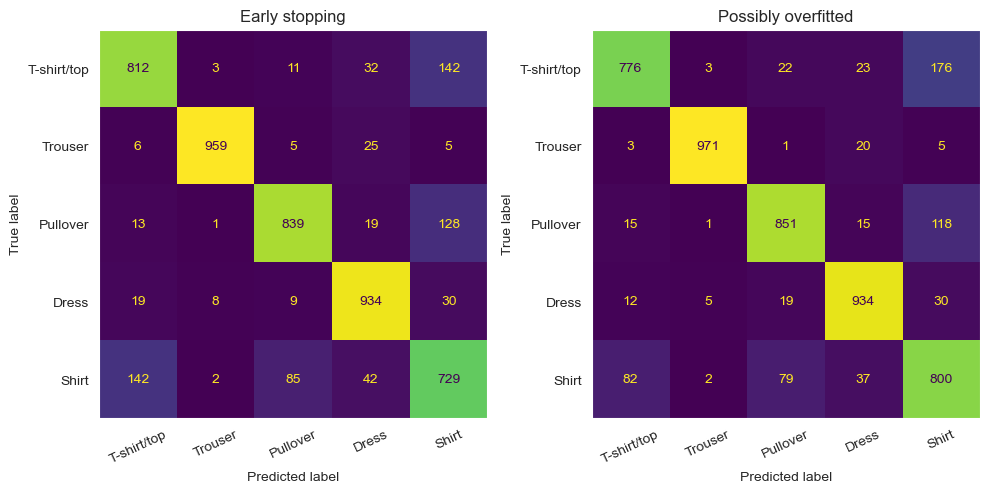

In [95]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=saved_nn_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[0], xticks_rotation=25,colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=conv_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[1], xticks_rotation=25, colorbar=False)

ax[0].grid(False)
ax[0].set_title("Early stopping")
ax[1].grid(False)
ax[1].set_title("Possibly overfitted")
fig.tight_layout()

We choose the early stopping method.

# Visualizing filters

In [231]:
def get_conv_layers(cnn):

    model_weights = []
    conv_layers = []
    model_children = list(cnn.children())


    for child in model_children:
        if type(child) == nn.Conv2d:
            model_weights.append(child.weight)
            conv_layers.append(child)
        elif type(child) == nn.Sequential:
            for grandchild in child:
                if type(grandchild) == nn.Conv2d:
                    model_weights.append(grandchild.weight)
                    conv_layers.append(grandchild)

    return conv_layers, model_weights
            

conv_layers, model_weights = get_conv_layers(conv_nn)
                

# filter shapes (conv layer sizes)
for weight, conv in zip(model_weights,conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")


CONV: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([6, 1, 5, 5])
CONV: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 6, 5, 5])


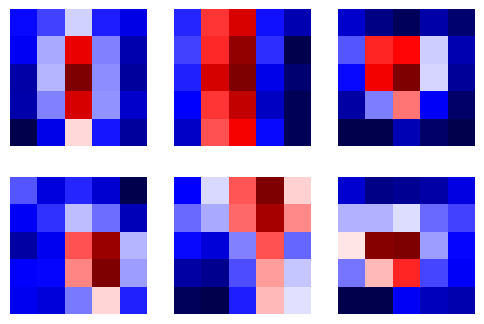

<Figure size 640x480 with 0 Axes>

In [232]:
# Visualizing first filters
cmap = plt.get_cmap("seismic_r")
plt.figure(figsize=(6,4))

for i, filter in enumerate(model_weights[0]):
    plt.subplot(2,3, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

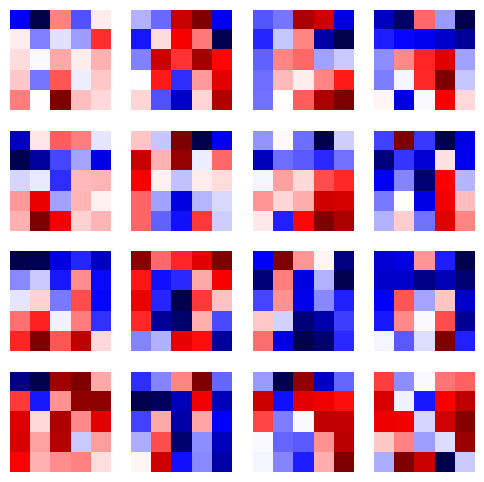

<Figure size 640x480 with 0 Axes>

In [233]:
# Visualizing second filters

plt.figure(figsize=(6,6))

for i, filter in enumerate(model_weights[1]):
    plt.subplot(4,4, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

In [234]:
def plot_img_with_convolution(conv_layers,idx):
    cmap = plt.get_cmap("seismic_r")
    # Visualising feature maps
    example_img = to_tensor(np.float32(X_train[idx].reshape(28,28))).to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

    # Create a mini model using only conv1

    model1 = nn.Sequential(conv_layers[0])

    output_conv1_convolution = model1(example_img)

    fig = plt.figure(figsize=(12,6))

    grid = gridspec.GridSpec(8, 16, figure=fig)

    # Creating the 2x3 subplot within the defined grid

    # left side (plots greyscale image)
    ax1 = fig.add_subplot(grid[2:6, :4])
    ax1.imshow(X_train[idx].reshape(28,28), cmap="grey")
    ax1.grid(False)
    ax1.set_title(f'Greyscale Image ({CLOTHING_TYPES[y_train[idx]]})')

    # Right side

    ax2 = fig.add_subplot(grid[4:, 4:8])
    ax2.imshow(output_conv1_convolution[0].detach().cpu().numpy(), cmap=cmap)
    ax2.grid(False)
    ax2.set_title('Filter 1')


    ax3 = fig.add_subplot(grid[4:, 8:12])
    ax3.imshow(output_conv1_convolution[1].detach().cpu().numpy(), cmap=cmap)
    ax3.grid(False)
    ax3.set_title('Subplot 3')


    ax4 = fig.add_subplot(grid[4:, 12:16])
    ax4.imshow(output_conv1_convolution[2].detach().cpu().numpy(), cmap=cmap)
    ax4.grid(False)
    ax4.set_title('Subplot 4')


    ax5 = fig.add_subplot(grid[:4, 4:8])
    ax5.imshow(output_conv1_convolution[3].detach().cpu().numpy(), cmap=cmap)
    ax5.grid(False)
    ax5.set_title('Subplot 5')


    ax6 = fig.add_subplot(grid[:4, 8:12])
    ax6.imshow(output_conv1_convolution[4].detach().cpu().numpy(), cmap=cmap)
    ax6.grid(False)
    ax6.set_title('Subplot 6')

    ax7 = fig.add_subplot(grid[:4, 12:16])
    ax7.imshow(output_conv1_convolution[5].detach().cpu().numpy(), cmap=cmap)
    ax7.grid(False)
    ax7.set_title('Subplot 7')

    fig.tight_layout()



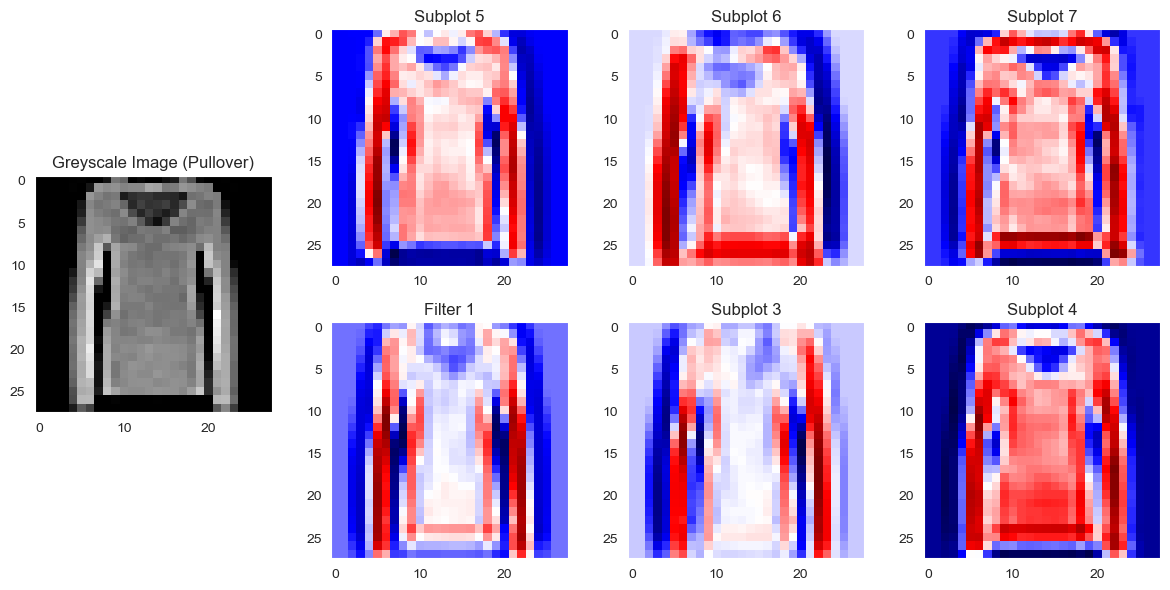

In [237]:
conv_layers_conv_nn, _ = get_conv_layers(conv_nn)
conv_layers_saved_nn, _ = get_conv_layers(saved_nn)

plot_img_with_convolution(conv_layers_conv_nn, 6)

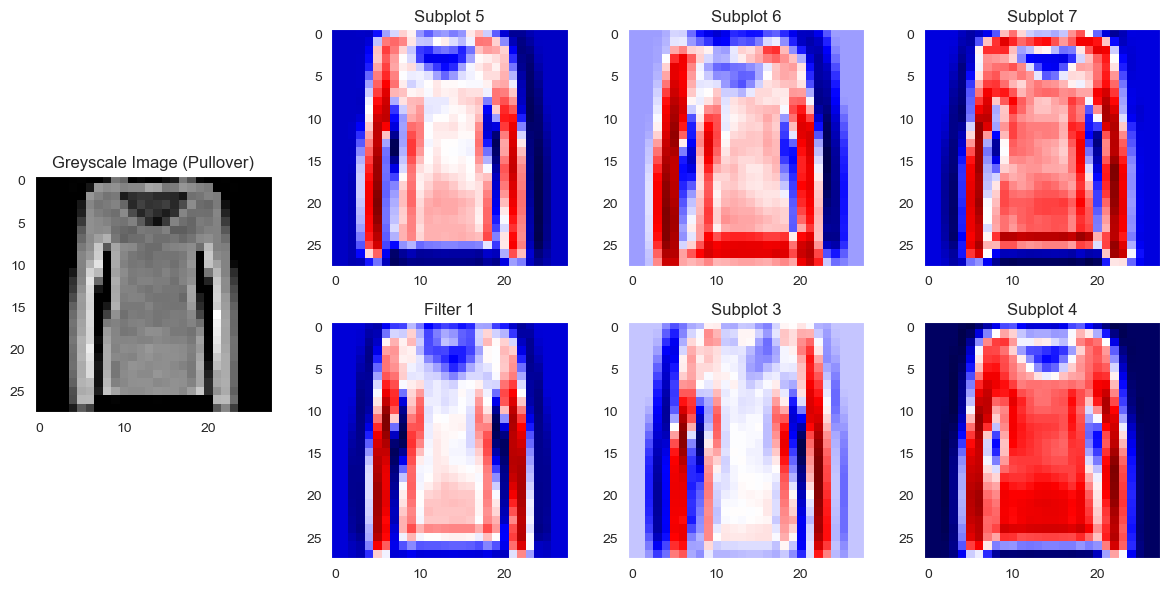

In [238]:
plot_img_with_convolution(conv_layers_saved_nn, 6)